In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_homoskedastic_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/Homoskedastic_CelebA_Ppc/0609_220802/checkpoint_1999.ckpt")

Missing logger folder: saved/log/Homoskedastic_CelebA_Ppc/0611_173305/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/Homoskedastic_CelebA_Ppc/0611_173305 exists and is not empty.
Restoring states from the checkpoint path at saved/models/Homoskedastic_CelebA_Ppc/0609_220802/checkpoint_1999.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/Homoskedastic_CelebA_Ppc/0609_220802' to '/workspace/shai_hulud/ppc_experiments/saved/models/Homoskedastic_CelebA_Ppc/0611_173305', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type         | Params
--------------------------------------------
0 | graph      | GeneratorPpc | 357 K 
1 | pre

Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_epochs=2000` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): GeneratorPpc(
    (prior): GaussianPrior()
    (likelihood): FixedVarianceDecoder(
      (mean_network): NLVM(
        (projection_layer): Projection(
          (linear): Linear(in_features=64, out_features=1024, bias=True)
          (deconv1): ConvTranspose2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          (linear_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (deconv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (deterministic_layer_1): Deterministic(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
 

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [9]:
with model.graph.condition(z=model.graph.nodes['z']['value']) as predictive:
    x_hats = predictive(B=len(xs), mode="prior", P=model.num_particles).mean(dim=0)

In [10]:
import matplotlib.pyplot as plt

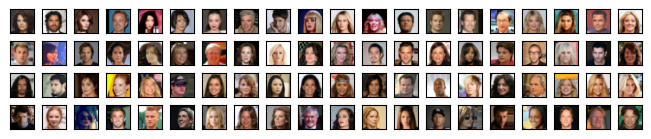

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        orgs = data.reverse_transform(xs[row * 20 + col].detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(orgs)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_homoskedastic_orgs.pdf", bbox_inches="tight")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


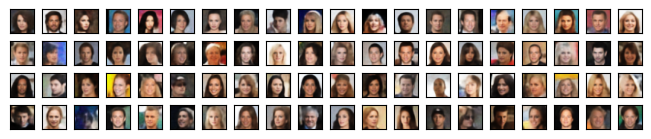

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_homoskedastic_recons.pdf", bbox_inches="tight")
plt.show()

In [13]:
del xs
del x_hats

In [14]:
model.graph.clear()

In [15]:
posterior = {k: torch.cat((v.detach(), model.particles["valid"][k].detach()), dim=1)
             for k, v in model.particles["train"].items()}
x_hats = model.graph.predict(B=8, P=model.num_particles, **posterior)
x_hats = torch.flatten(x_hats, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

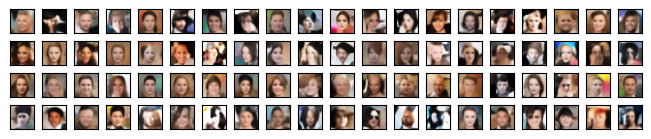

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].squeeze().detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_homoskedastic_predictive.pdf", bbox_inches="tight")
plt.show()

In [17]:
del x_hats

In [18]:
SEEDS = [123, 456, 789, 101112, 131415]

In [19]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [20]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)
            x_hats = model.graph(B=len(xs), mode="prior", P=model.num_particles)
            with model.graph.condition(X=xs) as predictive:
                trace, _ = predictive(B=len(xs), P=model.num_particles)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset) * model.num_particles
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset) * model.num_particles

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 10 under seed 0
Evaluated likelihood for valid batch 11 under seed 0
Evaluated likelihood for valid batch 12 under seed 0
Evaluated likelihood for valid batch 13 under seed 0
Evaluated likelihood for valid batch 14 under seed 0
Evaluated likelihood for valid batch 15 under seed 0
Evaluated likelihood for valid batch 16 under seed 0
Evaluated likelihood for valid batch 17 under seed 0
Evaluated likelihood for valid batch 18 under seed 0
Eva

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 5 under seed 1
Evaluated likelihood for valid batch 6 under seed 1
Evaluated likelihood for valid batch 7 under seed 1
Evaluated likelihood for valid batch 8 under seed 1
Evaluated likelihood for valid batch 9 under seed 1
Evaluated likelihood for valid batch 10 under seed 1
Evaluated likelihood for valid batch 11 under seed 1
Evaluated likelihood for valid batch 12 under seed 1
Evaluated likelihood for valid batch 13 under seed 1
Evaluated likelihood for valid batch 14 under seed 1
Evaluated likelihood for valid batch 15 under seed 1
Evaluated likelihood for valid batch 16 under seed 1
Evaluated likelihood for valid batch 17 under seed 1
Evaluated likelihood for valid batch 18 under seed 1
Eva

In [21]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-3115360.5000), tensor(17091.6582))

In [22]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0006), tensor(3.0918e-07))

In [23]:
model.graph.clear()

In [24]:
x_hats = model.graph(B=data.batch_size, mode="prior", P=model.num_particles).view(data.batch_size * model.num_particles, 3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

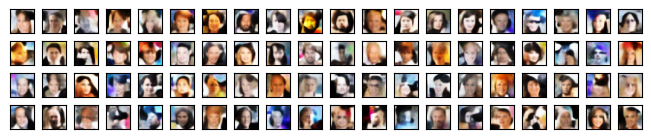

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].squeeze().detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_homoskedastic_prior.pdf", bbox_inches="tight")
plt.show()

In [26]:
fids = []

for batch_idx in range(10):
    xs, targets, indices = list(data.val_dataloader())[batch_idx]
    xs = xs.to(model.device)
    metrics = model.test_step((xs, targets, indices), batch_idx)
    fids.append(metrics['fid'])

fids = torch.stack(fids, dim=0)
fids.mean(), fids.std()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


(tensor(100.4479, device='cuda:7', dtype=torch.float64),
 tensor(7.1968, device='cuda:7', dtype=torch.float64))